# 1. Multi-class Classification of Beans

In [1]:
! pip install tensorflow-datasets

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense, Flatten, Conv2D, MaxPooling2D,Dropout,BatchNormalization,Input,Activation, RandomRotation, Resizing, RandomFlip, Rescaling, RandomTranslation,RandomContrast
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.optimizers import Adam,schedules, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG19
from bayes_opt import BayesianOptimization

In [3]:
# Load the dataset
ds, info = tfds.load('beans', with_info=True, as_supervised=True)

# Extract training, validation, and test sets
beans_train, beans_val, beans_test = ds['train'], ds['validation'], ds['test']

2024-06-07 13:10:04.205299: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-07 13:10:04.209019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


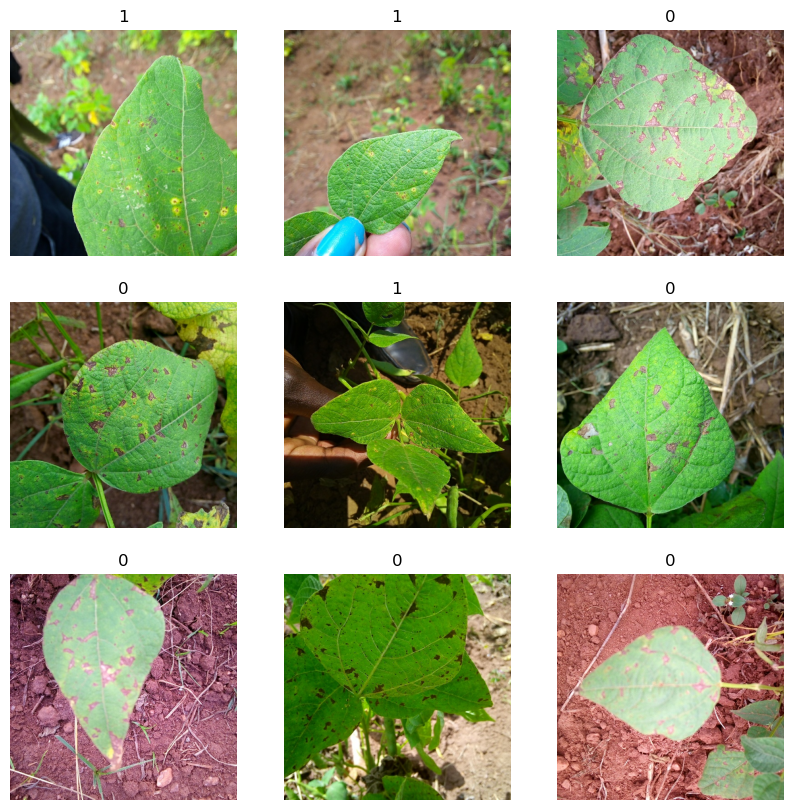

In [4]:
#View example figures with label in 3 x 3 grids
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(beans_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(int(label))
    plt.axis("off")

### Data Preprocessing

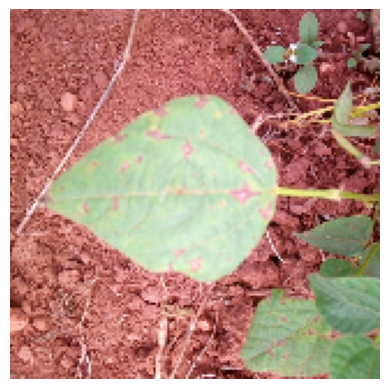

In [5]:
IMG_SIZE = 160

#resize and rescale the images
resize_and_rescale = Sequential([
  Resizing(IMG_SIZE, IMG_SIZE),
  Rescaling(1./255)
])

result = resize_and_rescale(image)
plt.axis('off')
plt.imshow(result);

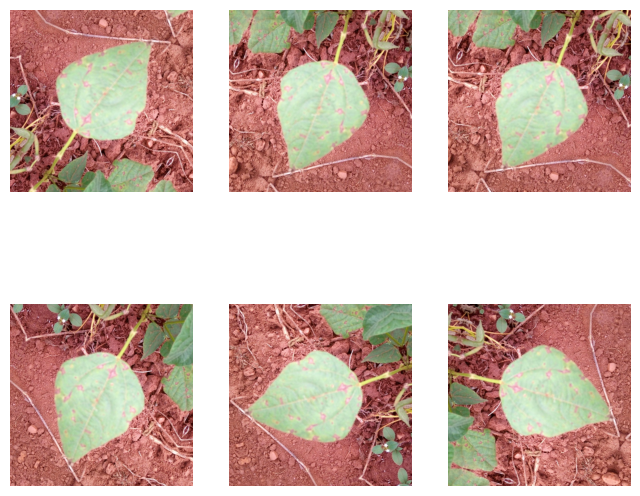

In [6]:
#data augmentation
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])


plt.figure(figsize=(8, 7))
for i in range(6):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(augmented_image.numpy()/255)
  plt.axis("off")

In [7]:
batch_size = 32
#AUTOTUNE = tf.data.AUTOTUNE

#data preprocessing
def prepare(ds, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y))
  
  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x), y))

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use buffered prefetching on all datasets
#  return ds.prefetch(buffer_size=AUTOTUNE)
  return ds

beans_train = prepare(beans_train, augment=True)
beans_val = prepare(beans_val)
beans_test = prepare(beans_test)

### Building CNN Model

In [14]:
#build cnn model
def beans_cnn(learning_rate=0.1,hidden_units=128,dropout_rate=0.3,filter_size=3,wd=0.01,stride=2):
    model = Sequential([
        Input(shape=(160, 160, 3)),
        Conv2D(32, (filter_size, filter_size),padding='same', strides=stride),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (filter_size, filter_size),padding='same',strides=stride),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (filter_size, filter_size),padding='same',strides=stride),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(hidden_units, kernel_regularizer=regularizers.l2(wd),kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),
        #multi-class classification, use softmax as activation function
        Dense(3,activation='softmax')
    ])
    
    #learning rate schedule
    initial_learning_rate = learning_rate
    lr_schedule = schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)
    
    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
model = beans_cnn()
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,707 (627.76 KB)

 Trainable params: 160,003 (625.01 KB)

 Non-trainable params: 704 (2.75 KB)

In [9]:
early_stoppping = EarlyStopping(monitor= 'val_loss', patience=3, mode='min', restore_best_weights=True)
history = model.fit(beans_train, validation_data=beans_val, epochs=30,verbose=False,callbacks=[early_stoppping])
model.evaluate(beans_test,verbose =2)

4/4 - 0s - 30ms/step - accuracy: 0.6250 - loss: 1.0910


[1.0910320281982422, 0.625]

### Bayesian Optimization

In [12]:
#use bayes optimization to tune hyperparameters
# Define the function to be optimized
def opt_function(learning_rate=0.001,hidden_units=128,dropout_rate=0.3,filter_size=3,wd=0.01,stride=1):
    wd = 10 ** wd
    learning_rate = 10 ** learning_rate
    hidden_units = round(hidden_units)
    stride = round(stride)
    #filter size should be odd
    filter_size = 2*round(filter_size)-1
    model = beans_cnn(learning_rate=learning_rate,hidden_units=hidden_units,
                      dropout_rate=dropout_rate,filter_size=filter_size,wd=wd,stride=stride)
    early_stoppping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True,mode='min')
    model.fit(beans_train, validation_data=beans_val, epochs=10,verbose=False,batch_size=32,callbacks=[early_stoppping])
    loss, accuracy = model.evaluate(beans_test,verbose=2)
    return accuracy

In [13]:
# add log10 to scale the weight decay and learning rate to make them equally spread
pounds = {'wd': (np.log10(0.0001), np.log10(0.01)),
          'filter_size': (2, 3),
           'hidden_units': (50, 200),
          # 'stride': (1, 2),
            'learning_rate': (np.log10(0.0001), np.log10(0.01)),
           'dropout_rate': (0.1, 0.5)}

optimizer = BayesianOptimization(
    f=opt_function,
    pbounds=pounds,
    random_state=123
)
#best parameters
optimizer.maximize(init_points=10,n_iter=4)
print(optimizer.max)

|   iter    |  target   | dropou... | filter... | hidden... | learni... |    wd     |
-------------------------------------------------------------------------------------
4/4 - 0s - 115ms/step - accuracy: 0.4062 - loss: 1.4140
| 1         | 0.4062    | 0.3786    | 2.286     | 84.03     | -2.897    | -2.561    |
4/4 - 1s - 287ms/step - accuracy: 0.3750 - loss: 1.7354
| 2         | 0.375     | 0.2692    | 2.981     | 152.7     | -3.038    | -3.216    |
4/4 - 1s - 260ms/step - accuracy: 0.3359 - loss: 1.3741
| 3         | 0.3359    | 0.2373    | 2.729     | 115.8     | -3.881    | -3.204    |
4/4 - 1s - 176ms/step - accuracy: 0.3438 - loss: 1.6579
| 4         | 0.3438    | 0.3952    | 2.182     | 76.32     | -2.937    | -2.936    |
4/4 - 1s - 287ms/step - accuracy: 0.4766 - loss: 1.5595
| 5         | 0.4766    | 0.3538    | 2.849     | 158.7     | -2.778    | -2.555    |
4/4 - 0s - 125ms/step - accuracy: 0.5234 - loss: 1.2857
| 6         | 0.5234    | 0.2292    | 2.362     | 84.24     | 

In [15]:
best_dropout_rate = optimizer.max['params']['dropout_rate']
best_hidden_units = round(optimizer.max['params']['hidden_units'])
best_learning_rate = 10 ** optimizer.max['params']['learning_rate']
best_wd = 10 ** optimizer.max['params']['wd']
best_filter_size = 2*round(optimizer.max['params']['filter_size'])-1
#best_stride = round(optimizer.max['params']['stride'])
best_accuracy = optimizer.max['target']

print(f"Best dropout rate: {best_dropout_rate}")
print(f"Best hidden units: {best_hidden_units}")
print(f"Best learning rate: {best_learning_rate}")
print(f"Best filter size: {best_filter_size}")
print(f"Best weight decay: {best_wd}")
print(f"Best accuracy: {best_accuracy}")

Best dropout rate: 0.2001821461586027
Best hidden units: 198
Best learning rate: 0.0010938814018257325
Best filter size: 3
Best weight decay: 0.0016818569396284953
Best accuracy: 0.6484375


In [34]:
#callback
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_accuracy'] > 0.9:
            print(f"\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

custom_callback = CustomCallback()

In [35]:
beans_model = beans_cnn(learning_rate=best_learning_rate,hidden_units=best_hidden_units,
                        dropout_rate=best_dropout_rate,wd=best_wd,filter_size=best_filter_size)
early_stoppping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True,mode='min')
history=beans_model.fit(beans_train,
                         validation_data=beans_val, 
                         epochs=100,
                         verbose=False,
                         batch_size=32,
                         callbacks=[early_stoppping,custom_callback])
beans_model.evaluate(beans_test,verbose=2)

4/4 - 0s - 33ms/step - accuracy: 0.8750 - loss: 0.5312


[0.5312178134918213, 0.875]

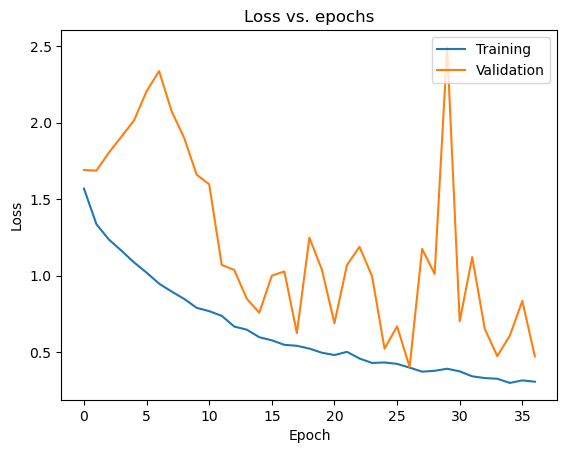

In [36]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

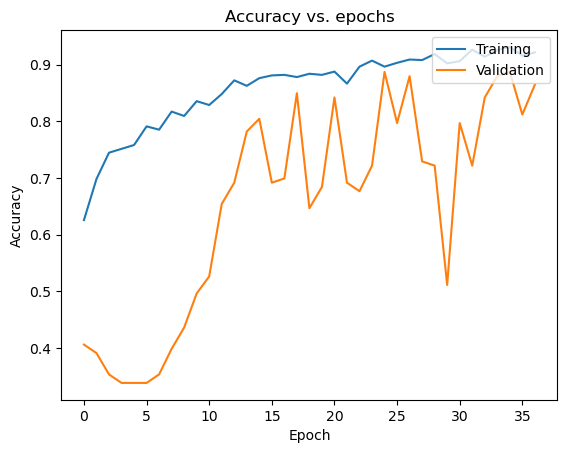

In [37]:
#plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


## 2. Transfer Learning of Dogs and Cats Classification

In [28]:
#take 10% of the overall data for training and validation sets, cd stands for cats vs dogs
(cd_train, cd_val),info = tfds.load(
    'CatsVsDogs',
    split=['train[:8%]', 'train[8%:10%]'],
    with_info=True,
    as_supervised=True,
)

2024-06-07 13:28:15.983328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


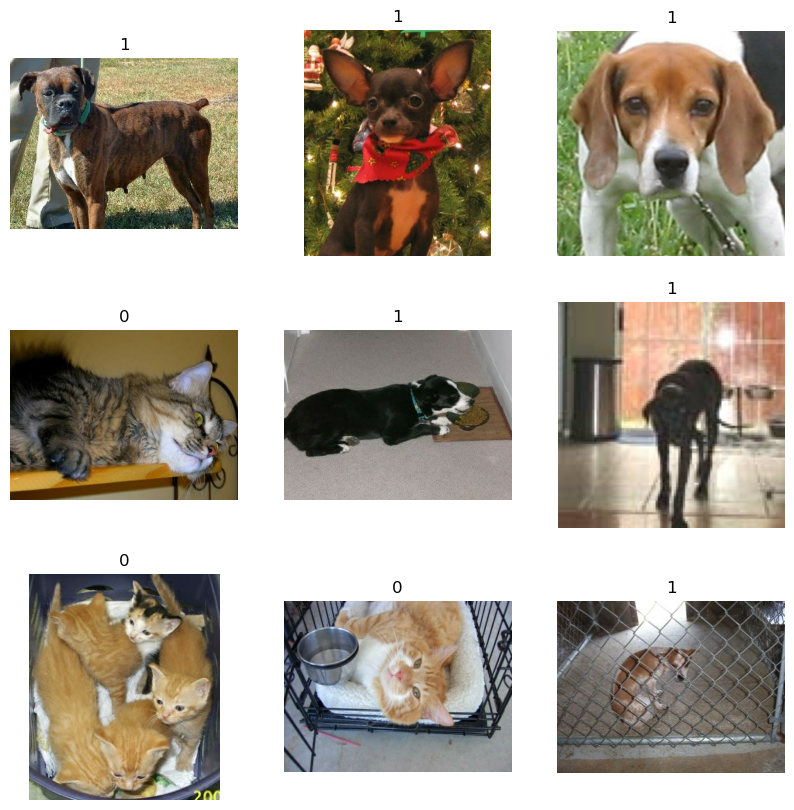

In [29]:
#View example figures with label in 3 x 3 grids
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(cd_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(int(label))
    plt.axis("off")

### Data Preprocessing

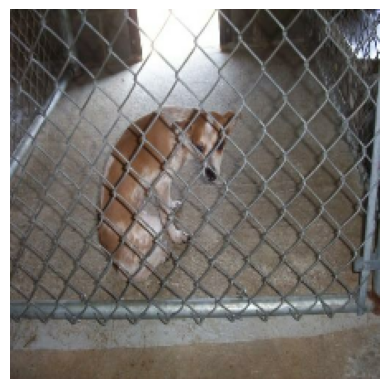

In [30]:
IMG_SIZE = 224

#resize and rescale the images
resize_and_rescale = Sequential([
  Resizing(IMG_SIZE, IMG_SIZE),
  Rescaling(1./255)
])

result = resize_and_rescale(image)
plt.axis('off')
plt.imshow(result);

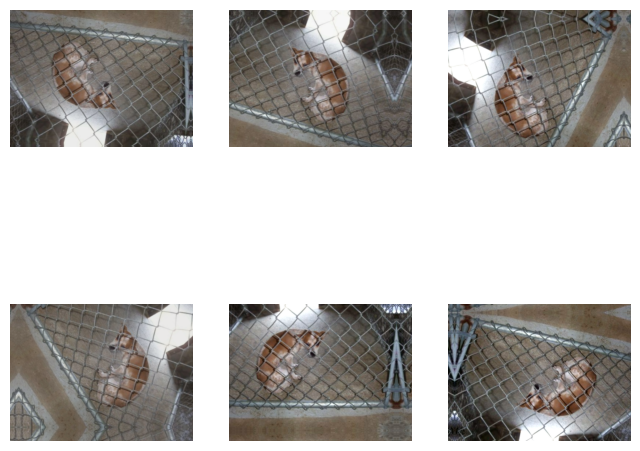

In [31]:
#data augmentation
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
  RandomTranslation(height_factor=0.1, width_factor=0.1),
  RandomContrast(factor=0.2),
])


plt.figure(figsize=(8, 7))
for i in range(6):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(augmented_image.numpy()/255)
  plt.axis("off")

In [32]:
cd_train = prepare(cd_train, augment=True)
cd_val = prepare(cd_val)

### Use ResNet50 pretrained model to fit data

In [41]:
#build transfer learning model
base_model = InceptionV3(input_shape=(224, 224, 3),include_top=False,weights='imagenet')

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [42]:
#add customer layer
# Add a global spatial average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512)(x)
# Add batch normalization
x = BatchNormalization()(x)
# Add ReLU activation
x = Activation('relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(64)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# Add a logistic layer for binary classification
predictions = Dense(1, activation='sigmoid')(x)

# Construct the final model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer = Adam(learning_rate= 0.0001), loss = 'binary_crossentropy',metrics = ['accuracy'])


In [43]:
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation_6[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_7[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_8[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_9[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,028,257 (87.85 MB)

 Trainable params: 1,223,553 (4.67 MB)

 Non-trainable params: 21,804,704 (83.18 MB)

In [44]:
initial_epochs = 10

In [46]:

inception_hist = model.fit(cd_train, validation_data = cd_val,  epochs = initial_epochs)

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 50s 855ms/step - accuracy: 0.6303 - loss: 0.6990 - val_accuracy: 0.9742 - val_loss: 0.3618
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 52s 879ms/step - accuracy: 0.6787 - loss: 0.6176 - val_accuracy: 0.9785 - val_loss: 0.2713
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 922ms/step - accuracy: 0.7278 - loss: 0.5480 - val_accuracy: 0.9828 - val_loss: 0.2118
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7650 - loss: 0.4957 - val_accuracy: 0.9849 - val_loss: 0.1705
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 58s 988ms/step - accuracy: 0.7839 - loss: 0.4664 - val_accuracy: 0.9849 - val_loss: 0.1365
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8119 - loss: 0.4170 - val_accuracy: 0.9871 - val_loss: 0.1144
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8453 - loss: 0.3689 - val_accuracy: 0.9849 - val_loss: 0.0985
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8506 - loss: 0.3486 - val_accuracy: 0.9871

In [47]:
acc = inception_hist.history['accuracy']
val_acc = inception_hist.history['val_accuracy']

loss = inception_hist.history['loss']
val_loss = inception_hist.history['val_loss']

### Learning Curves

Below is the learning curves of the training and validation accuracy/loss using ResNet50 pretrained model.

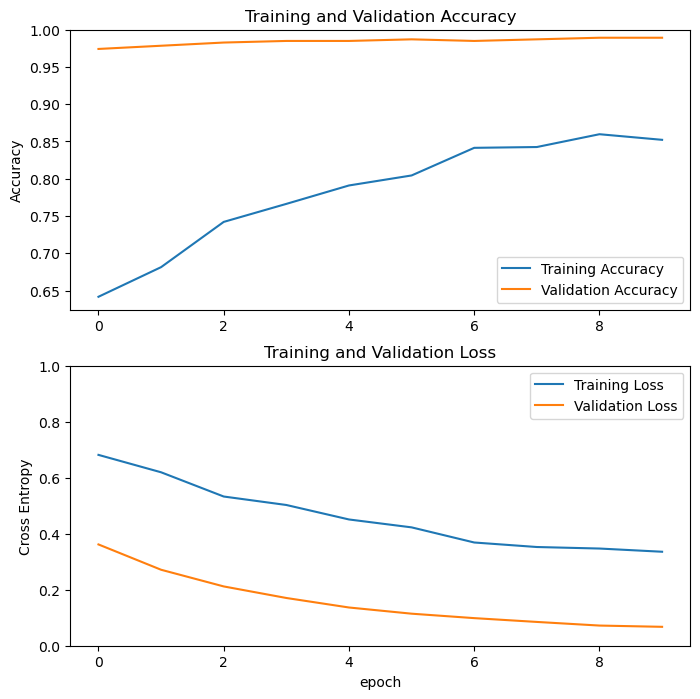

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine Tuning

Because we only used 10% of the whole dataset, the dataset size is small. On the other hand, the images of cats and dogs are not similar with each other, so the data similarity is also low. It is senario 2.

Thus we chose to freeze the initial k layers of the pre-trained model, and make the rest n-k layers trainable.

In [49]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


We can freeze the first 100 layers and unfreeze the rest layers.

In [50]:
# Fine-tune from this layer onwards
base_model.trainable = True

k = 100

# freeze the first k layers
for layer in base_model.layers[:k]:
  layer.trainable = False

# unfreeze the rest layers
for layer in base_model.layers[k:]:
  layer.trainable = True

In [51]:
# compile the model
model.compile(optimizer = Adam(learning_rate= 0.0001), loss = 'binary_crossentropy',metrics = ['accuracy'])

model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation_6[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_7[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_8[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_9[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,028,257 (87.85 MB)

 Trainable params: 20,849,921 (79.54 MB)

 Non-trainable params: 2,178,336 (8.31 MB)

In [52]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
inception_hist_fine = model.fit(cd_train, validation_data = cd_val,  epochs = total_epochs)

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7820 - loss: 0.4556 - val_accuracy: 0.9828 - val_loss: 0.0589
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.8818 - loss: 0.3009 - val_accuracy: 0.9871 - val_loss: 0.0489
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.8827 - loss: 0.2622 - val_accuracy: 0.9871 - val_loss: 0.0553
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.9203 - loss: 0.2165 - val_accuracy: 0.9849 - val_loss: 0.0493
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.9417 - loss: 0.1762 - val_accuracy: 0.9828 - val_loss: 0.0626
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.9399 - loss: 0.1756 - val_accuracy: 0.9828 - val_loss: 0.0500
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9612 - loss: 0.1428 - val_accuracy: 0.9892 - val_loss: 0.0553
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9633 - loss: 0.1352 - val_accuracy: 0.9828 - v

In [53]:
acc += inception_hist_fine.history['accuracy']
val_acc += inception_hist_fine.history['val_accuracy']

loss += inception_hist_fine.history['loss']
val_loss += inception_hist_fine.history['val_loss']

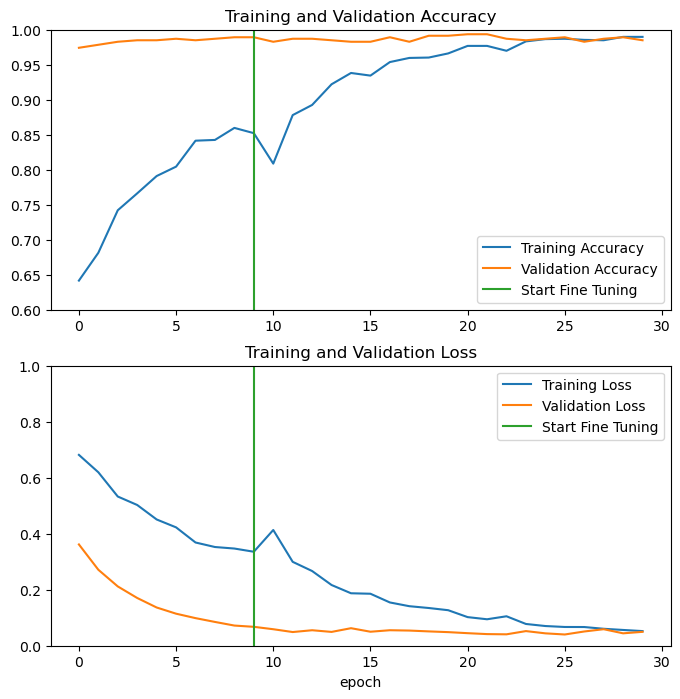

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()